Eu não usei todas essas bibliotecas, mas eu importo só pra manter na memória como chama cada uma delas...

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

In [2]:
df = pd.read_csv('winequality-red.csv')

# Avaliando NaNs, Infs, DTypes, e df.shape em uma só linha!

In [3]:
ProfileReport(df,minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Por meio da análise desse gráfico, foi possível realizar as seguintes observações:
* Nenhum valor NaN ou Inf em todo o DataSet (Extremamente limpo!)
* Todas as features são Quantitativas Contínuas! (Não há a necessidade de realizar nenhuma dummyzação, ou transformação de variáveis qualitativas ordinais em quantitativas discretas, pois elas não existem)
* A variável de interesse é Quantitativa Discreta! 
    * Opções: Regressão, Classificação, ou Clusterização. Clusterização seria bem menos recomendado mas também é uma possibilidade! Veremos mais sobre isso futuramente.
* 11 Features e 1599 observações (Quantidade de variáveis é mais do que o suficiente para realizar aplicar um bom modelo!)

# Análise de Outliers e Distribuição das features

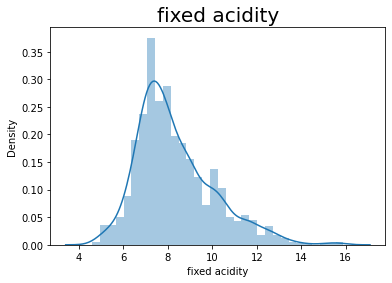

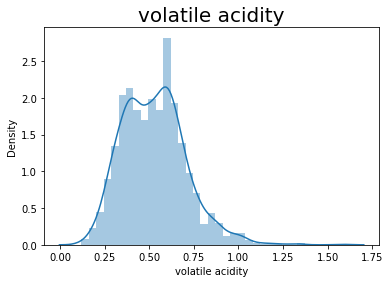

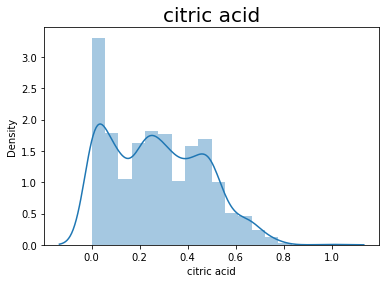

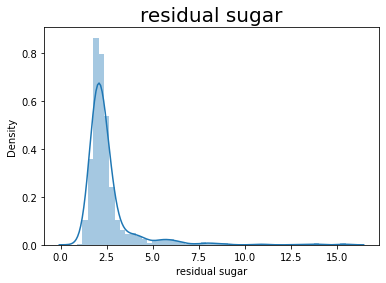

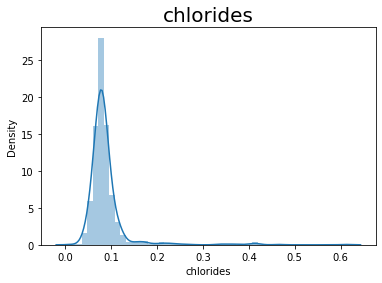

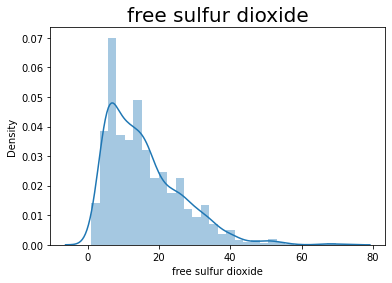

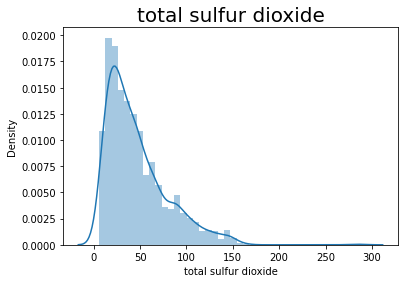

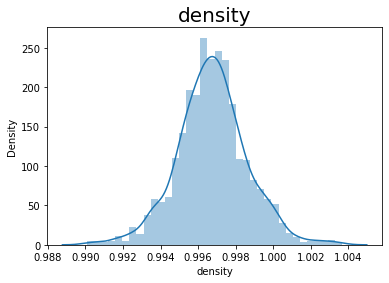

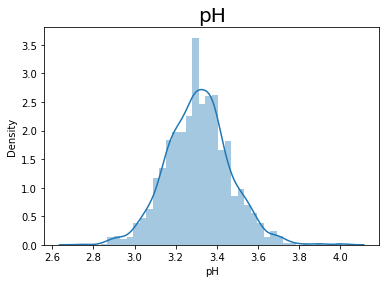

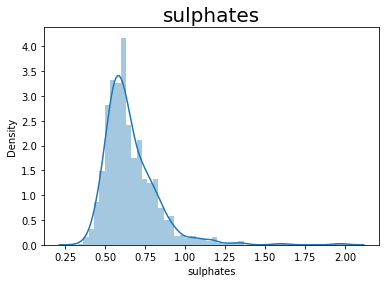

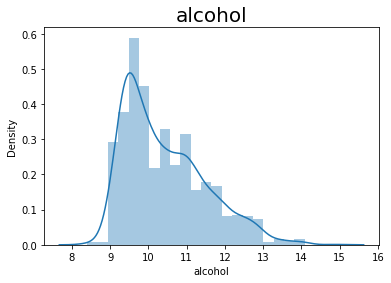

In [4]:
for i in df.drop(columns='quality').columns:
    plt.figure()
    plt.title(i,fontsize =20)
    sns.distplot(df[i])
    plt.show()

Todas as features aparentam seguir uma distribuição normal. Obviamente o nível de assimetria (Skewness) e curtose (Kurtosis) varia de variável para variável, e nunca será perfeito, mas no geral TODAS AS FEATURES aparentam seguir uma normal, o que já é muito bom, e o esperado para variáveis quantitativas.

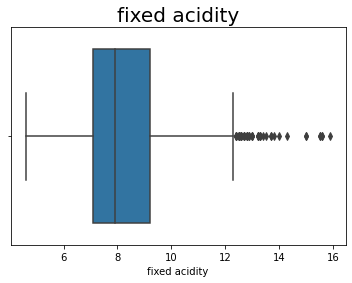

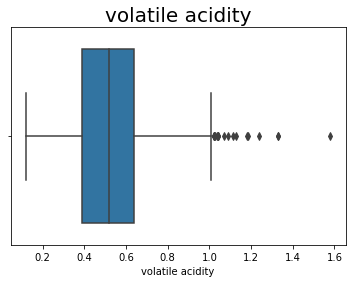

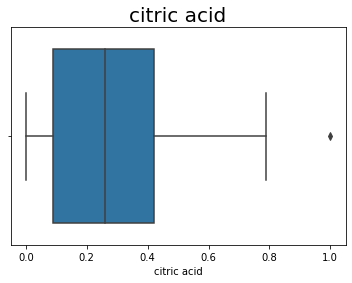

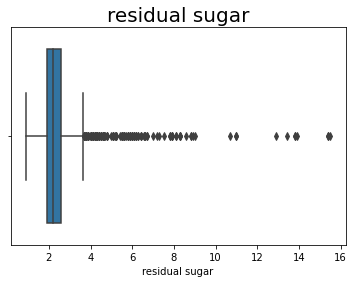

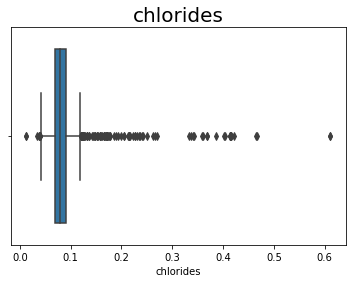

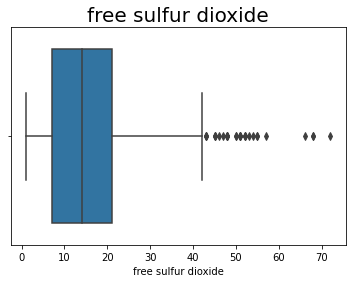

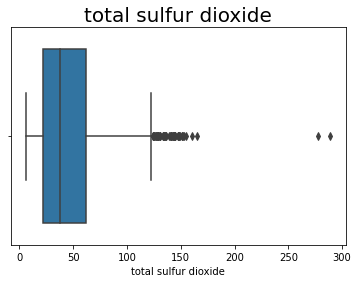

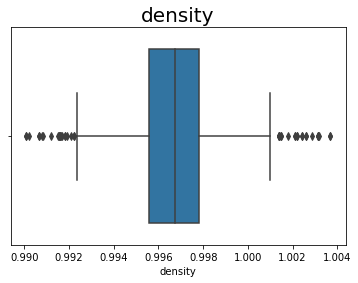

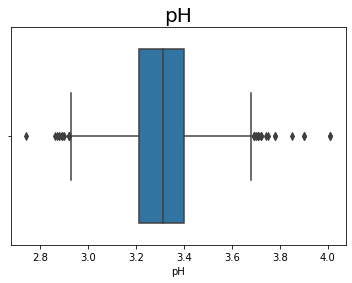

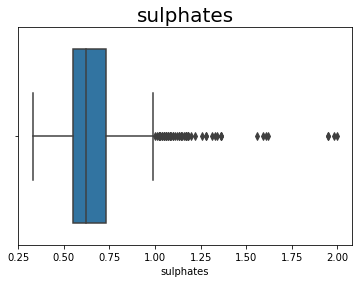

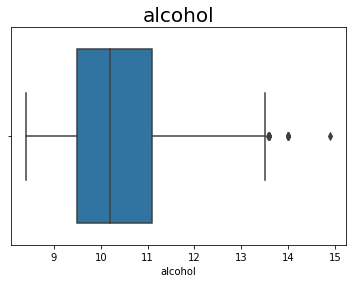

In [5]:
for i in df.drop(columns='quality').columns:
    plt.figure()
    plt.title(i,fontsize =20)
    sns.boxplot(df[i])
    plt.show()

Por meio dos boxplots, foi possível verificar a presença forte de Outliers em muitas das features. Apesar disso, é muito improvável que esses outliers tenham sido resultado de algum erro de cálculo ou no momento de input dos valores, pois os seus valores não são absurdos demais (Ex: Um boxplot cujo intervalo interquartil, ou "corpo" do boxplot é quase invisível devido aos outliers), portanto, não se recomenda eliminar nenhuma dessas variáveis! É necessário uma outra metodologia para tratar os dados que falaremos mais a respeito futuramente...

### Vamos sair dos gráficos e observar os valores por si!

In [6]:
df.drop(columns='quality').describe(percentiles=[0.1,0.25,0.75,0.9])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
10%,6.500000,0.310000,0.010000,1.700000,0.060000,5.000000,14.000000,0.994556,3.120000,0.500000,9.300000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
90%,10.700000,0.745000,0.522000,3.600000,0.109000,31.000000,93.200000,0.999140,3.510000,0.850000,12.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


* Em algumas variáveis, ao compararmos o 90º percentil com os seus valores máximos, verificamos distorções significativas! Isso indica a presença forte de outliers nelas. (Porém não são tãaaao absurdas assim...)
* Outra observação válida seria o fato de que as variáveis apresentam suas médias muito próximas das suas medianas, o que é também uma excelente métrica para verificar a presença ou não de Outliers nos dados, que distorceriam a média BASTANTE se os outliers realmente fossem absurdos. 
* Além disso, verifica-se uma significativa diferença nos valores mínimos e máximos para cada uma das variáveis, o que indica que elas estão em diferentes escalas, e isso exigirá algum tipo de normalização. Opções: MinMaxScaler, StandardScaler. Selecionaremos o StandardScaler!
  * MinMaxScaler força todas as variáveis a assumirem valores entre 0 e 1.
  * StandardScaler fornece a todas as variáveis um valor com base em seus desvios padrões, bom para dados com muitos Outliers, os quais poderiam distorcer os dados no MinMaxScaler

# Analisando se os dados estão desbalanceados

---------------------------------------- Analisando se os dados estão desbalanceados ----------------------------------------


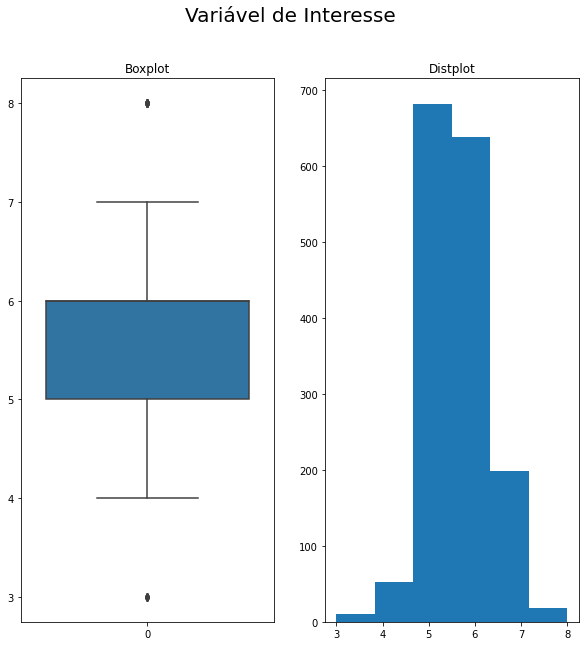

---------------------------------------- Quantidade de Observações Para Cada Dimensão ----------------------------------------


,quality
5,681
6,638
7,199
4,53
8,18
3,10


In [7]:
print('-'*40 +' Analisando se os dados estão desbalanceados '+ '-'*40)
fig, [axs1,axs2] = plt.subplots(1,2,figsize=(10,10))
fig.suptitle('Variável de Interesse',fontsize=20)
axs1.title.set_text('Boxplot')
sns.boxplot(data = df['quality'],ax=axs1)
axs2.title.set_text('Distplot')
axs2.hist(df['quality'],bins=6)
plt.show()
print('-'*40 +' Quantidade de Observações Para Cada Dimensão '+ '-'*40)

pd.DataFrame(df['quality'].value_counts())

### Observações:
* A variável de interesse, também aparenta apresentar uma distribuição normal (Maior concentração de observações entre os valores 5 e 6)
* Possui uma elevada dimensionalidade (6 valores possíveis)
* Não está bem balanceada no momento (Não possui a mesma quantidade de observações para cada dimensão).

# Seleção de Modelos!

A variável de interesse é uma variável quantitativa discreta, o que significa que o problema poderá ser resolvido por meio de 3 diferentes modelos: Clusterização, Regressão, ou Classificação.

### Para a modelagem teremos 3 caminhos possíveis:
* #### Modelos de Clusterização.
    * Descrição: Geralmente aplicados quando queremos "separar" diversas observações em grupos distintos. Porém, também podem ser aplicados para esse problema, por mais que seja bem inaconselhável.
    * Procedimentos: Inicialmente, realiza-se um procedimento para descobrir o número de grupos, o que não será necessário no nosso caso, pois já sabemos as dimensões existentes, que são 6. Depois compara-se os resultados com as métricas de desempenho existentes.
    * Desvantagens: O modelo de clustering NÃO APRENDE de acordo com dados que já foram classificados, portanto não existe sequer a separação de Training e Testing aqui. Porém ainda há a possibilidade (mínima) de ele se sair melhor que os modelos de regressão ou classificação...
    * Melhores modelos à nossa disposição: Meanshift, GaussianMixture, Hierarchical Clustering.
    * Métricas de Desempenho: As mesmas dos modelos de Classificação e Regressão.
* #### Modelos de Classificação.
    * Descrição: Geralmente aplicados quando JÁ SABEMOS OS GRUPOS QUE EXISTEM e queremos atribuir um grupo para cada observação nova.
    * Vantagens: Resultados mais claros, pois problemas de classificação podem envolver variáveis qualitativas nominais, qualitativas ordinais, ou quantitativas discretas.
    * Desvantagens: Dados extremamente desbalanceados, o que exigirá um forte UNDERSAMPLING das categorias que contém a maior quantitade de amostras, fazendo com que acabemos perdendo muitas observações. Outra opção seria rodar o modelo normal sem o Undersampling, mas com, obviamente, um desempenho comprometido. (Qual dos 2 seria menos ruim??)  
    * Melhores modelos à nossa disposição: KNN (Nearest Neighbours), Naive Bayes, RandomForestClassifier, GradientBoostingClassifier, MLPClassifier.
    * Métricas de Desempenho (Serão utilizados Tanto para classificação quanto para Clusterização): Acurácia (Inaconselhável para dados desbalanceados), F1Score, Precision (Foco nos falsos positivos), e Recall (Foco nos falsos negativos)
* #### Modelos de Regressão.
    * Descrição: Realizados para obter valores numéricos contínuos para uma variável de interesse de acordo com valores de uma série de features.
    * Vantagens: Dados desbalanceados não afetarão o resultado final, além disso a variável de interesse, na teoria deveria variar de 0 a 10, e apenas modelos de regressão poderão verificar se uma nova observação poderá estar acima de 8 ou abaixo de 3, que são grupos que não foram ainda verificados e não poderiam ser mensurados por Classificação ou Clustering!!
    * Desvantagens: Problemas de regressão envolvem variáveis quantitativas CONTÍNUAS! A variável de interesse se trata de uma variável quantitativa DISCRETA, porém como os valores gerado por esses algorítmos são contínuos, os resultados não serão claros como os dos modelos de classificação.
    * Melhores modelos à nossa disposição para teste: RandomForestRegressor, GradientBoostingRegressor, MLPRegressor, 
    * Métricas de Desempenho: MSQE (Mean Squared Error), MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error).

### Tuning dos Modelos:

Será feito por meio de:

* Cross-Validation --> Para decidir o modelo principal a se utilizar (Ex: Random Forest, Naive Bayes, etc)
* HiperParameter Tuning --> GridSearch ou BayesSearch (Vão testando vários hiperparâmetros e vendo quais apresentam as melhores métricas de desempenho), feito só depois que JÁ DECIDIMOS O MODELO PRINCIPAL ESCOLHIDO (Ex: verificar a partir de qual nó seria melhor podar as árvores de decisão no Random Forest, etc.)

### Etapa final:

Compararemos os modelos de classificação e clusterização por meio de suas métricas de desempenho. No caso dos modelos de regressão, como suas métricas são diferente das dos demais modelos, precisa-se usar o bom senso para verificar qual deles será mais adequado ao nosso caso (Caso um ou outro modelo estaja MUITO ruim perceptivelmente, também pode-se optar por descartar ele sem ter que pensar muito).